# Import Libraries

In [5]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

# Model Description 




## Fitness function 
We assume that cells grow at a rate $F(z)$ where $z$ is the concentration of a deleterious TF. We assume that before the TF is induced, cells double approximately every 1.5 hrs. After inducation, cells pay a fitness penalty proportional to the number of TFs which are bound to off target sites. 
This leads to the fitness function 
\begin{equation}
F(z) = \lambda\left(1- \delta f\frac{z}{K_z + z}\right).
\end{equation}
Here, $\delta f$ is the fitness payed when the off target sites are saturated and $K_z$ is the dissociation constant of th TF and the binding cite. $\delta f$ is strain dependent while $K_z$ is a tunable parameter which sets the concentration scale. $K_z$ can range from $10^{-2}$ to $10^2$ $\mu M$ (**Based on figure board from Nikit**), but we work in units of TFs per cell. If a typical yeast cell is about $10^{-15}$ L, this translates to a range of $1$ to $10^4$ for $K_z$. 

## TF production and mutations
The TF is produced at a rate $\alpha$ (per cell) in the functional cells and not produced in the broken cells, while cells can mutate from functional to broken at a rate $\mu$ per unit time (we are assuming that the mutation rate does not depend on the doubling time). We know that the mutation rate per generation is roughly $3.5 \times 10^{-10}$ and there are likely $100s$ of sites on the genome which can obtain a circuit breaking mutation. Thus the per hour rate to get a circuit breaking mutation in a single-lineage is 
 \begin{equation}
 \mu = 3.5 \times 10^{-10} \times \frac{1}{1.5} \times 100 \approx 2.53 \times 10^{-8}
 \end{equation}

 Since there are roughly $10^8$ cells in the population, the average time we will have to wait to see a mutation is on the order of $10$ hours. It is therefore reasonable to expect that we see mutation emerge both before inducation (since populations are grown for abour $18$ hours) and after inducation before the existing mutants have dominated the population. 


## Dynamics

We now develop an ODE model of the dynamics of TF concentrations in the broken and functional cells.  Note this model assumes the initial number of mutants is sufficiently large so that demographic fluctuations can be neglected.  Although the experiments are performed in a continuous culture, for simplicity we model the population dynamics as exponential growth. Since the goal is to understand the dynamics of growth rates, there should be no distinction.


 Under these assumptions, the number of functional and broken cells evolve as
\begin{align}
\frac{d}{dt}x_f &= F(z_f)x_f - \mu x_f\\
\frac{d}{dt}x_b &= F(z_b)x_b + \mu x_f
\end{align}
Letting $m_f$ denote the number of TFs in functional cells, we have 
\begin{equation}
\frac{d}{dt}m_f = \alpha x_f - \mu m_f
\end{equation}
The second term comes from the fact that $\mu x_f$ functional cells mutate per unit time, each taking $z_f = m_f/x_f$ TFs with it. 
The equation for the TF concentration in functional cells is therefore
\begin{align}
\frac{d}{dt}z_f &= \frac{d}{dt}\frac{m_f}{x_f} =  \alpha- \mu z_f - z_f(F(z_f) - \mu)\\
&=\alpha - F(z_f)  z_f
\end{align}

Notice that the dynamics of $z_f$ do not depend on $\mu$, since when a function cell mutant the number of TFs among functional cells changes from $m_f$ to $m_f - z_f$, while the number of functional cells is decreased by $1$. Thus, the change TF concentration after the mutation event is zero:
\begin{equation}
\delta z_f = \frac{m_f-z_f}{x_f-1} -z_f =\frac{z_f(x_f -1)}{x_f-1} -z_f= 0.
\end{equation}


For broken cells, the situation is a bit different. In this case, we have
\begin{equation}
\frac{d}{dt}m_b = \mu z_fx_f,
\end{equation}
which implies 
\begin{align}
\frac{d}{dt}z_b &= \mu z_f\frac{x_f}{x_b} - z_b\left(F(z_b) + \mu\frac{x_f}{x_b}\right)\\
&=  -z_bF(z_b) + \mu \frac{x_f}{x_b} (z_f - z_b).
\end{align}




# Simulations

Here we define a function which simulations the ODE model of the population dynamics imediately after inducation, assuming that the initial number of mutants in the population is large enough to neglect demographic fluctuations. 



In [6]:
def run(alpha,mu,fitness,xtot,mut_frac):
    nt = 100000 # time steps
    tmax = 100 # time to run simulations
    dt = tmax/nt
    
    # setup 
    t_range = np.linspace(0,tmax,nt) # time grid
    xf = np.zeros(nt) # cells with functioning circuits 
    xb = np.zeros(nt) # cells with broken 
    zf = np.zeros(nt) # TF concentration (TF per cell) in function cells
    zb = np.zeros(nt) # TF concentration (TF per cell) in broken cells

    # set initial conditions
    xf[0] = xtot*(1-mut_frac)
    xb[0] = xtot*mut_frac
    zf[0] = 0.0
    zb[0] = 0.0

    for k in range(1,nt):
        muz = fitness(zf[k-1])*mu/fitness(0)
        xf[k] = xf[k-1] + fitness(zf[k-1])*xf[k-1]*dt - muz*xf[k-1]*dt 
        xb[k] = xb[k-1] + fitness(zb[k-1])*xb[k-1]*dt + muz*xf[k-1]*dt
        zf[k] = zf[k-1] + alpha*dt-fitness(zf[k-1])*zf[k-1]*dt
        zb[k] = zb[k-1] - fitness(zb[k-1])*zb[k-1]*dt + mu*xf[k-1]/xb[k-1]*(zf[k-1]-zb[k-1])*dt
    
    x_tot = xf+xb
    gr = (x_tot[1:]-x_tot[:-1])/x_tot[:-1]/dt 
    return xf,xb,zf,zb,gr,t_range

In [7]:
mu = 3.8*10.**(-10.)*100/1.5 # mutation rate is mutation per base pair (3.8*10^-10)/generation time (1.5 hours), 100s of potential mutation sites
alpha =1. # rate of TF production

# fitness function 
def hill(z,Kz,df,c):
  return (1.-df*z/(Kz+z+c*z))

## Effect of $K_z$ and $\delta f$

We now test if we can reproduce the qualitative features of the dynamics of fitness after inducation, putting aside the quantitative disagreement seen the in previous section. To do so, we fix the TF production rate, the mutation rate and the initial mutant fraction and change two parameters: $K_z$ and $\delta f$. The former corresponds to changing the TF affinity while the later corresponds to changing the strain. Different strains may have different fitness costs, but the same $K_z$. 

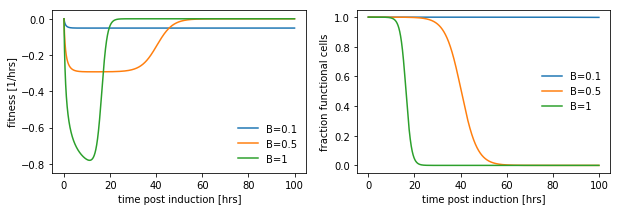

In [8]:
# Figure 1: Changing Fitness cost

fig,axs = plt.subplots(ncols=2,figsize=(10,3),sharex=True)

xtot = 10e8         # Population Size
mut_frac = 10e-6    # Fraction mutated (broken circuit)
Kz = 1.             # TF-DNA affinity
df1 = 0.1           # Low fitness cost
df2 = 0.5           # Medium fitness cost
df3 = 1.            # High fitness cost

# Simulations

# Low fitness cost
xf,xb,zf,zb,gr,t_range = run(alpha,mu,lambda z:hill(z,Kz,df1,0.),xtot,mut_frac)
axs[0].plot(t_range[:-1],gr-gr[0],label='B=0.1')
axs[1].plot(t_range,xf/(xf+xb),label='B=0.1')

# Medium fitness cost
xf,xb,zf,zb,gr,t_range = run(alpha,mu,lambda z:hill(z,Kz,df2,0.),xtot,mut_frac)
axs[0].plot(t_range[:-1],gr-gr[0],label='B=0.5')
axs[1].plot(t_range,xf/(xf+xb),label='B=0.5')

# High fitness cost
xf,xb,zf,zb,gr,t_range = run(alpha,mu,lambda z:hill(z,Kz,df3,0.),xtot,mut_frac)
axs[0].plot(t_range[:-1],gr-gr[0],label='B=1')
axs[1].plot(t_range,xf/(xf+xb),label='B=1')


# Label Axes
axs[0].set_ylabel('fitness [1/hrs]')
axs[0].set_xlabel('time post induction [hrs]')
axs[0].set_ylim([-0.85,0.05])
axs[0].legend(frameon=False)

axs[1].set_ylabel('fraction functional cells')
axs[1].set_xlabel('time post induction [hrs]')
axs[1].set_ylim([-0.05,1.05])
axs[1].legend(frameon=False)

# Save figure
plt.savefig('./changing_fitness_cost.pdf',bbox_inches='tight')

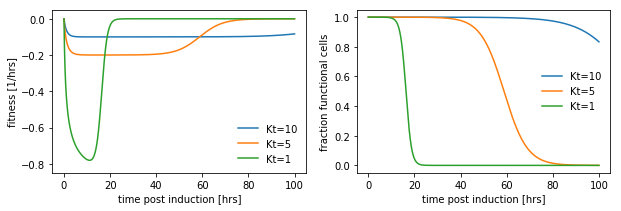

In [9]:
# Figure 2: Changing affinity

fig,axs = plt.subplots(ncols=2,figsize=(10,3),sharex=True)

xtot = 10e8         # Population Size
mut_frac = 10e-6    # Fraction mutated (broken circuit)
Kz1 = 10.           # Low TF-DNA Affinity
Kz2 = 5.            # Medium TF-DNA Affinity
Kz3 = 1.            # High TF-DNA Affinity
df = 1              # Maximum fitness cost

# Simulations

# Low TF-DNA Affinity
xf,xb,zf,zb,gr,t_range = run(alpha,mu,lambda z:hill(z,Kz1,df,0.),xtot,mut_frac)
axs[0].plot(t_range[:-1],gr-gr[0],label='Kt=10')
axs[1].plot(t_range,xf/(xf+xb),label='Kt=10')

# Medium TF-DNA Affinity
xf,xb,zf,zb,gr,t_range = run(alpha,mu,lambda z:hill(z,Kz2,df,0.),xtot,mut_frac)
axs[0].plot(t_range[:-1],gr-gr[0],label='Kt=5')
axs[1].plot(t_range,xf/(xf+xb),label='Kt=5')

# High TF-DNA Affinity
xf,xb,zf,zb,gr,t_range = run(alpha,mu,lambda z:hill(z,Kz3,df,0.),xtot,mut_frac)
axs[0].plot(t_range[:-1],gr-gr[0],label='Kt=1')
axs[1].plot(t_range,xf/(xf+xb),label='Kt=1')


# Label Axes
axs[0].set_ylabel('fitness [1/hrs]')
axs[0].set_xlabel('time post induction [hrs]')
axs[0].set_ylim([-0.85,0.05])
axs[0].legend(frameon=False)

axs[1].set_ylabel('fraction functional cells')
axs[1].set_xlabel('time post induction [hrs]')
axs[1].set_ylim([-0.05,1.05])
axs[1].legend(frameon=False)

# Save figure
plt.savefig('./changing_affinity.pdf',bbox_inches='tight')